# Week 4: Handling Complex Images - Happy or Sad Dataset

In this assignment you will be using the happy or sad dataset, which contains 80 images of emoji-like faces, 40 happy and 40 sad.

Create a convolutional neural network that trains to 99.9% accuracy on these images,  which cancels training upon hitting this training accuracy threshold.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

2022-09-20 20:40:20.778782: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-20 20:40:20.781809: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-20 20:40:20.781818: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load and explore the data

Begin by taking a look at some images of the dataset.

Notice that all the images are contained within the `./data/` directory. 

This directory contains two subdirectories `happy/` and `sad/` and each image is saved under the subdirectory related to the class it belongs to.

In [4]:
import os 
wd = os.getenv('wd')

Sample happy image:


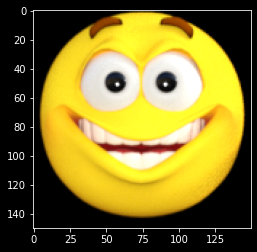


Sample sad image:


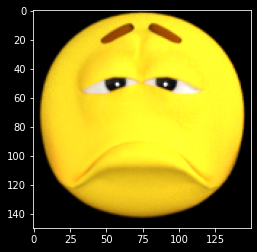

In [6]:
from tensorflow.keras.preprocessing.image import load_img

base_dir = wd + 'C1'+"/data/"
happy_dir = os.path.join(base_dir, "happy/")
sad_dir = os.path.join(base_dir, "sad/")

print("Sample happy image:")
plt.imshow(load_img(f"{os.path.join(happy_dir, os.listdir(happy_dir)[0])}"))
plt.show()

print("\nSample sad image:")
plt.imshow(load_img(f"{os.path.join(sad_dir, os.listdir(sad_dir)[0])}"))
plt.show()


It is cool to be able to see examples of the images to better understand the problem-space you are dealing with. 

However there is still some relevant information that is missing such as the resolution of the image (although matplotlib renders the images in a grid providing a good idea of these values) and the maximum pixel value (this is important for normalizing these values). For this you can use Keras as shown in the next cell:

In [7]:
from tensorflow.keras.preprocessing.image import img_to_array

# Load the first example of a happy face
sample_image  = load_img(f"{os.path.join(happy_dir, os.listdir(happy_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

print(f"The maximum pixel value used is: {np.max(sample_array)}")

Each image has shape: (150, 150, 3)
The maximum pixel value used is: 255.0


Looks like the images have a resolution of 150x150. **This is very important because this will be the input size of the first layer in your network.** 

**The last dimension refers to each one of the 3 RGB channels that are used to represent colored images.**

## Defining the callback

Since you already have coded the callback responsible for stopping training (once a desired level of accuracy is reached) in the previous two assignments this time it is already provided so you can focus on the other steps:

In [8]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.999:
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

A quick note on callbacks: 

So far you have used only the `on_epoch_end` callback but there are many more. For example you might want to check out the [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback, which allows you to save the best weights for your model.

## Pre-processing the data

Keras provides great support for preprocessing image data. A lot can be accomplished by using the `ImageDataGenerator` class. Be sure to check out the [docs](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) if you get stuck in the next exercise. In particular you might want to pay attention to the `rescale` argument when instantiating the `ImageDataGenerator` and to the [`flow_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory) method.

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# GRADED FUNCTION: image_generator
def image_generator():
    ### START CODE HERE

    # Instantiate the ImageDataGenerator class.
    # Remember to set the rescale argument.
    train_datagen = ImageDataGenerator(rescale=1./255)

    # Specify the method to load images from a directory and pass in the appropriate arguments:
    # - directory: should be a relative path to the directory containing the data
    # - targe_size: set this equal to the resolution of each image (excluding the color dimension)
    # - batch_size: number of images the generator yields when asked for a next batch. Set this to 10.
    # - class_mode: How the labels are represented. Should be one of "binary", "categorical" or "sparse".
    #               Pick the one that better suits here given that the labels are going to be 1D binary labels.
    train_generator = train_datagen.flow_from_directory(directory=wd + 'C1'+"/data/",
                                                        target_size=(150, 150),
                                                        batch_size=10,
                                                        class_mode='binary')
    ### END CODE HERE

    return train_generator
    

In [10]:
# Save your generator in a variable
gen = image_generator()

Found 80 images belonging to 2 classes.


**Expected Output:**
```
Found 80 images belonging to 2 classes.
```

## Creating and training your model

Finally, complete the `train_happy_sad_model` function below. This function should return your  neural network.

**Your model should achieve an accuracy of 99.9% or more before 15 epochs to pass this assignment.**

**Hints:**
- You can try any architecture for the network but keep in mind that the model will work best with 3 convolutional layers. 


- In case you need extra help you can check out some tips at the end of this notebook.

In [11]:
from tensorflow.keras import optimizers, losses

# GRADED FUNCTION: train_happy_sad_model
def train_happy_sad_model(train_generator):

    # Instantiate the callback
    callbacks = myCallback()

    ### START CODE HERE

    # Define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (150,150,3)),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(128,(3,3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation = 'relu'),
        tf.keras.layers.Dense(1,activation='sigmoid')
    ])

    # Compile the model
    # Select a loss function compatible with the last layer of your network
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr = 0.001),
                  metrics=['accuracy']) 
    


    # Train the model
    # Your model should achieve the desired accuracy in less than 15 epochs.
    # You can hardcode up to 20 epochs in the function below but the callback should trigger before 15.
    history = model.fit(x= train_generator,
                        epochs=15,
                        callbacks=[callbacks]

                       ) 
    
    ### END CODE HERE
    return history

In [13]:
hist = train_happy_sad_model(gen)

Epoch 1/15


2022-09-20 20:56:34.913453: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-20 20:56:34.913470: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-20 20:56:34.913486: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cargamos-dev): /proc/driver/nvidia/version does not exist
2022-09-20 20:56:34.913676: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/cargamos/Documents/personal/Deep-Learning-Specialization/venv/lib/python3.10/site-pa

8/8 [==============================] - 1s 131ms/step - loss: 2.5128 - accuracy: 0.5750
Epoch 2/15
8/8 [==============================] - 1s 134ms/step - loss: 0.4836 - accuracy: 0.7500
Epoch 3/15
8/8 [==============================] - 1s 126ms/step - loss: 0.3049 - accuracy: 0.8750
Epoch 4/15
8/8 [==============================] - 1s 135ms/step - loss: 0.1657 - accuracy: 0.9375
Epoch 5/15
8/8 [==============================] - 1s 123ms/step - loss: 0.1069 - accuracy: 0.9625
Epoch 6/15
8/8 [==============================] - 1s 127ms/step - loss: 0.2559 - accuracy: 0.9000
Epoch 7/15
8/8 [==============================] - 1s 129ms/step - loss: 0.0720 - accuracy: 0.9750
Epoch 8/15
8/8 [==============================] - 1s 128ms/step - loss: 0.2254 - accuracy: 0.9125
Epoch 9/15
8/8 [==============================] - 1s 129ms/step - loss: 0.0510 - accuracy: 0.9750
Epoch 10/15
8/8 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 1.0000
Reached 99.9% accuracy so cancelling

If you see the message that was defined in the callback printed out after less than 15 epochs it means your callback worked as expected and training was successful. You can also double check by running the following cell:

In [14]:
print(f"Your model reached the desired accuracy after {len(hist.epoch)} epochs")

Your model reached the desired accuracy after 10 epochs


If your callback didn't stop training, one cause might be that you compiled your model using a metric other than `accuracy` (such as `acc`). Make sure you set the metric to `accuracy`. You can check by running the following cell:

In [15]:
if not "accuracy" in hist.model.metrics_names:
    print("Use 'accuracy' as metric when compiling your model.")
else:
    print("The metric was correctly defined.")

The metric was correctly defined.


## Need more help?

Run the following cell to see some extra tips for the model's architecture.

In [ ]:
import base64

encoded_answer = "ClNvbWUgaGVscGZ1bCB0aXBzIGluIGNhc2UgeW91IGFyZSBzdHVjazoKCiAgICAtIEEgZ29vZCBmaXJzdCBsYXllciB3b3VsZCBiZSBhIENvbnYyRCBsYXllciB3aXRoIGFuIGlucHV0IHNoYXBlIHRoYXQgbWF0Y2hlcyAKICAgIHRoYXQgb2YgZXZlcnkgaW1hZ2UgaW4gdGhlIHRyYWluaW5nIHNldCAoaW5jbHVkaW5nIHRoZSBjb2xvciBkaW1lbnNpb24pCiAgICAKICAgIC0gVGhlIG1vZGVsIHdpbGwgd29yayBiZXN0IHdpdGggMyBjb252b2x1dGlvbmFsIGxheWVycwogICAgCiAgICAtIFRoZXJlIHNob3VsZCBiZSBhIEZsYXR0ZW4gbGF5ZXIgaW4gYmV0d2VlbiBjb252b2x1dGlvbmFsIGFuZCBkZW5zZSBsYXllcnMKICAgIAogICAgLSBUaGUgZmluYWwgbGF5ZXIgc2hvdWxkIGJlIGEgRGVuc2UgbGF5ZXIgd2l0aCB0aGUgbnVtYmVyIG9mIHVuaXRzIGFuZCAKICAgIGFjdGl2YXRpb24gZnVuY3Rpb24gdGhhdCBzdXBwb3J0cyBiaW5hcnkgY2xhc3NpZmljYXRpb24uCg=="
encoded_answer = encoded_answer.encode('ascii')
answer = base64.b64decode(encoded_answer)
answer = answer.decode('ascii')

print(answer)

**Congratulations on finishing the last assignment of this course!**

You have successfully implemented a CNN to assist you in the classification task for complex images. Nice job!

**Keep it up!**